# Titanic - Who will survive?
### Liam Gameng
The Titanic, a British passenger liner, sank in the North Atlantic Ocean on 15 April 1912, after
striking an iceberg during her maiden voyage from Southampton to New York City. Of the
estimated 2,224 passengers and crew aboard, more than 1,500 died, making the sinking at the
time one of the deadliest of a single ship and the deadliest peacetime sinking of a superliner or
cruise ship to date. This project allows us to gain insight into how to survive from such a
catastrophe, is it pure luck or is it something else?

**Useful Variable Definitions:** \
Survival - Did the passenger survive? (0 = No, 1 = Yes)\
pclass - Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)\
Sibsp - Number of siblings and spouses aboard the Titanic\
Parch - Number of parents and children aboard the Titanic\
Embarked - Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

## Exploratory Data Analysis
Before we can produce models to determine whether or not a passenger survives based on the training data, we must first determine what features of the dataset are predictive of survival. This will be done through exploratory data analysis after doing any necessary data cleaning, where relationships between certain variables will be analyzed.

### Data Cleaning
The first step in the exploratory data analysis process is to clean the data, which means the features should be analyzed to determine what features should be dropped and if any additonal inputation or deletion is necessary. But first, the proper packages should be imported and as well as the data to be used for training and testing

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import random as rand
from matplotlib import pyplot as plt
import seaborn as sns

# Importing modeling algorithms
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metric
from sklearn.model_selection import train_test_split

# Importing training csv file
df = pd.read_csv('train.csv')

# Rename Pclass
df = df.rename(columns={'Pclass': 'TicketClass'})

Next we check for missing features and duplicates for the entries in the dataset.

In [2]:
# find total null values for each feature
df.isnull().sum()

PassengerId      0
Survived         0
TicketClass      0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [3]:
# find number of duplicate entries
df.duplicated().sum()

0

As shown above, the training set has not duplicate entries. However, there are "Age" values missing for 177 passengers, "Cabin" values missing for 687 passengers, and "Embarked" values missing for 2 passengers. Since there is so much missing data for "Cabin", it is fair to drop this features from the dataset. Since "Age" is likely an important factor in survival rate, due to the idea of giving prioirity to women and children for lifeboats, and since "Embarked" is only missing for two entries these features should be kept.

In [4]:
# Dropping the 'Cabin' feature
df = df.drop(['Cabin'], axis = 1)

Now that this feature is dropped, let's analyze the remaining features to better understand the dataset

In [5]:
# Print first five entries of the dataset to see how features are represented
df.head(5)

,PassengerId,Survived,TicketClass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


After seeing this representation, it is pretty clear that "PassengerId" is simply an index for the data and this feature can be dropped. Also, the "Name" data seems a bit messy and is likely not too useful for predicting survival. The only potential use for names would be to get their titles (i.e. Mr., Mrs., Lord), but this feature would likely not give us additonal information given the gender and class of each passenger is known data.

In [6]:
# Drop 'PassengerId' and 'Name' features
df = df.drop(['PassengerId', 'Name'], axis = 1)
df.head(5)

,Survived,TicketClass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,female,35.0,1,0,113803,53.1000,S
4,0,3,male,35.0,0,0,373450,8.0500,S


In addition to these features, the "SibSp" and "Parch" features likely can be combined in order to get a "FamilySize" feature since this will likely reflect similar patterns to each individual feature.

In [7]:
# Adding number of siblings, parents, and children to get a family size and dropping 'SibSp' and 'Parch' features
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df = df.drop(['SibSp', 'Parch'], axis = 1)
df.head(5)

,Survived,TicketClass,Sex,Age,Ticket,Fare,Embarked,FamilySize
0,0,3,male,22.0,A/5 21171,7.2500,S,2
1,1,1,female,38.0,PC 17599,71.2833,C,2
2,1,3,female,26.0,STON/O2. 3101282,7.9250,S,1
3,1,1,female,35.0,113803,53.1000,S,2
4,0,3,male,35.0,373450,8.0500,S,1


Now let's analyze the data first by using 'describe' on the categorical data.

In [8]:
# Describe categorical data
df.describe(include=['O'])

,Sex,Ticket,Embarked
count,891,891,889
unique,2,681,3
top,male,347082,S
freq,577,7,644


The categorical data shows that there are a significant amount of duplicate tickets, and based on viewing the data it seems like the "Ticket" feature will likely not be too useful for predicting survivability. It is likely this feature is somewhat dependent on the location of embarking and the class of the ticket anyway.

In [9]:
# Drop 'ticket' feature
df = df.drop(['Ticket'], axis = 1)

Now is also a good time to consider how data should be represented when training a model. It is probably best to represent categorical data as a numerical value, such as assigning '0' to 'male' and '1' to female for the "Sex" features and since there are only 3 unique values for the "Embarked" feature this can also be converted to in integer value. '1' will be assigned to Cherbourg, '2' to Queenstown, and '3' to Southampton. However, we have two entries with missing "Embarked" features which will simply be inputed with the most used port of embarkation.

In [10]:
# Inputing missing 'Embarked' values with most embarked port
most_embarked = df.Embarked.dropna().mode()[0]
df['Embarked'] = df['Embarked'].fillna(most_embarked)

In [11]:
# Converting categorical data to numeric data
df['Sex'] = df['Sex'].map( {'male': 0, 'female': 1} ).astype(int)
df['Embarked'] = df['Embarked'].map( {'C': 1, 'Q': 2, 'S': 3} ).astype(int)
df.head(5)

,Survived,TicketClass,Sex,Age,Fare,Embarked,FamilySize
0,0,3,0,22.0,7.2500,3,2
1,1,1,1,38.0,71.2833,1,2
2,1,3,1,26.0,7.9250,3,1
3,1,1,1,35.0,53.1000,3,2
4,0,3,0,35.0,8.0500,3,1


Now that all of the data is represented in a numerical form, we can begin to analyze the data to see how we should deal with outliers. It is also clear that only two of the remaining features have floating point values, which means that these two features can be dealt with in an intertesting way when it comes to dealing with outliers. The data can be analyzed in order to convert the "Age" and "Fare" features into discrete values based on brackets, which in turn will get rid of any potential outlier values. After calling 'describe' below it is evident that outliers exist for these features. However, if values were bracketed this would remove outliers and create a better form of data to train a model.

In [12]:
# Describe the modifed dataframe
df.describe()

,Survived,TicketClass,Sex,Age,Fare,Embarked,FamilySize
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.699118,32.204208,2.536476,1.904602
std,0.486592,0.836071,0.477990,14.526497,49.693429,0.791503,1.613459
min,0.000000,1.000000,0.000000,0.420000,0.000000,1.000000,1.000000
25%,0.000000,2.000000,0.000000,20.125000,7.910400,2.000000,1.000000
50%,0.000000,3.000000,0.000000,28.000000,14.454200,3.000000,1.000000
75%,1.000000,3.000000,1.000000,38.000000,31.000000,3.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,512.329200,3.000000,11.000000


However, before we do this it is definitely necessary to deal with the missing data points for the "Age" feature. It is likely that this feature has some form of correlation with the "Ticket Class" and "Family Size" features, so lets test to see if correlations exist.

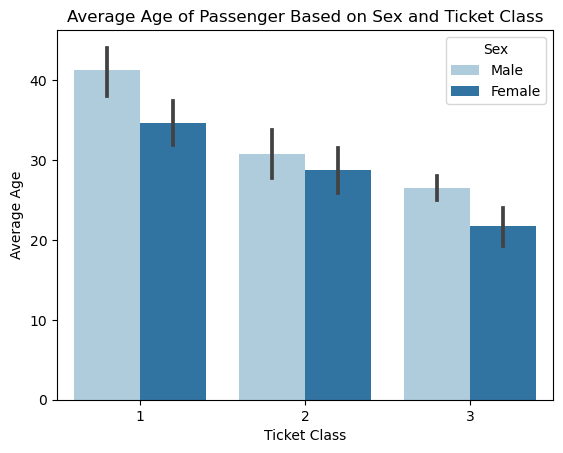

In [13]:
# Creating bar graph to analyze if there are significant differences in average age based on ticket class and sex
temp_df = df.copy()
temp_df['Sex'] = temp_df['Sex'].map( {0 : 'Male', 1 : 'Female'} ).astype(str)
age_graph = sns.barplot(data = temp_df, x="TicketClass", y="Age", hue = "Sex", palette = "Paired")
age_graph.set_title('Average Age of Passenger Based on Sex and Ticket Class')
age_graph.set_ylabel('Average Age')
age_graph.set_xlabel('Ticket Class')
plt.legend(title = 'Sex')
plt.show()

As demonstrated above, there seems to be significant differences between the "Age" feature statistics based on the "Ticket Class" and "Sex" features, and therefore we can categorize entries with existing "Age" features based on these data points. Then in order to create an estimate age for each combination of "Ticket Class" and "Sex", use the mean value from each combination as the "Age" for entries with corresponding features. Then for simplicity convert all of the age values to integers.

In [14]:
# Assign missing values with the mean age for each combination of 'Ticket Class' and 'Sex'
df['Age'] = df['Age'].fillna(df.groupby(["TicketClass", "Sex"])["Age"].transform("mean"))

# Converting ages to integer for simplicity
df['Age'] = df['Age'].astype(int)
print("Number of missing feature values:")
print(df.isnull().sum())
df.head(5)

Number of missing feature values:
Survived       0
TicketClass    0
Sex            0
Age            0
Fare           0
Embarked       0
FamilySize     0
dtype: int64


,Survived,TicketClass,Sex,Age,Fare,Embarked,FamilySize
0,0,3,0,22,7.2500,3,2
1,1,1,1,38,71.2833,1,2
2,1,3,1,26,7.9250,3,1
3,1,1,1,35,53.1000,3,2
4,0,3,0,35,8.0500,3,1


The final step in data cleaning that will be done is dealing with outliers. However, for this dataset I don't want to simply remove the outlier entries but instead group them into brackets. To determine how brackets should be divided the survival rates for different divisions will be graphed to determine which makes the most sense. First the age will be divided into equal groups using Pandas' 'cut' function, and visualize the survival rate for each bracket. If it seems like the rates are well divided, then the cutting parameters are reasonable and the "Age" feature will be changed to an index indicating the age range of the passenger.

Text(0.5, 0, 'Age')

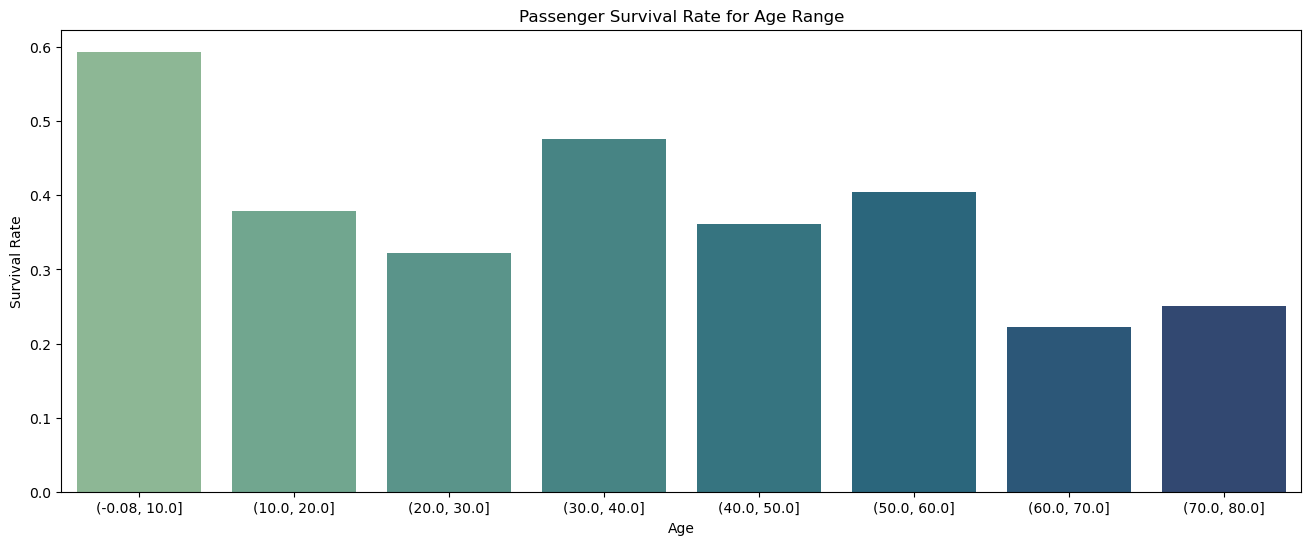

In [15]:
# Divide ages into nine equal ranges
df['AgeRange'] = pd.cut(df['Age'], 8)
age_df = pd.DataFrame(df[['AgeRange', 'Survived']].groupby(['AgeRange'],
                                                           as_index=False).mean().sort_values(by='AgeRange', ascending=True))

plt.figure(figsize=(16, 6))
age_range_graph = sns.barplot(data = age_df, x = "AgeRange", y = "Survived", palette = "crest")
age_range_graph.set_title('Passenger Survival Rate for Age Range')
age_range_graph.set_ylabel('Survival Rate')
age_range_graph.set_xlabel('Age')

In [16]:
# Converting age to age range in the 'Age' feature
df.loc[df['Age'] <= 10, 'Age'] = 1
df.loc[(df['Age'] > 10) & (df['Age'] <= 20), 'Age'] = 2
df.loc[(df['Age'] > 20) & (df['Age'] <= 30), 'Age'] = 3
df.loc[(df['Age'] > 30) & (df['Age'] <= 40), 'Age'] = 4
df.loc[(df['Age'] > 40) & (df['Age'] <= 50), 'Age'] = 5
df.loc[(df['Age'] > 50) & (df['Age'] <= 60), 'Age'] = 6
df.loc[(df['Age'] > 60) & (df['Age'] <= 70), 'Age'] = 7
df.loc[df['Age'] > 70, 'Age'] = 8
df['Age'] = df['Age'].astype(int)
df = df.drop(['AgeRange'], axis=1)

df.head(5)

,Survived,TicketClass,Sex,Age,Fare,Embarked,FamilySize
0,0,3,0,3,7.2500,3,2
1,1,1,1,4,71.2833,1,2
2,1,3,1,3,7.9250,3,1
3,1,1,1,4,53.1000,3,2
4,0,3,0,4,8.0500,3,1


Now since we found a suitable way to divide the ages into different brackets, now the fares should be divided as well. While the ages are better distributed, the 'describe' function showed that the fares are likely very skewed. For this reason instead we will make usage of Pandas' 'qcut' function to divide into groups based on frequency in the ranges, not simply creating evenly spaced ranges.

Text(0.5, 0, 'Fare')

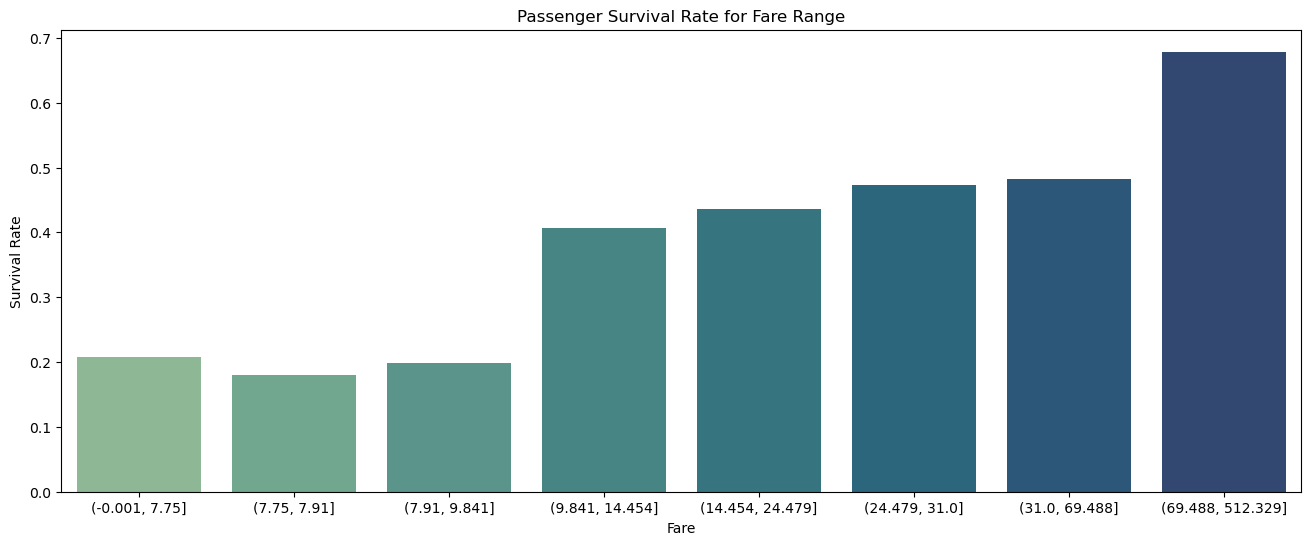

In [17]:
# Divide ages into five equal frequency ranges
df['FareRange'] = pd.qcut(df['Fare'], 8)
fare_df = pd.DataFrame(df[['FareRange', 'Survived']].groupby(['FareRange'],
                                                           as_index=False).mean().sort_values(by='FareRange', ascending=True))

plt.figure(figsize=(16, 6))
fare_range_graph = sns.barplot(data = fare_df, x = "FareRange", y = "Survived", palette = "crest")
fare_range_graph.set_title('Passenger Survival Rate for Fare Range')
fare_range_graph.set_ylabel('Survival Rate')
fare_range_graph.set_xlabel('Fare')

In [18]:
# Converting fare to fare range in the 'Fare' feature
df.loc[df['Fare'] <= 7.75, 'Fare'] = 1
df.loc[(df['Fare'] > 7.75) & (df['Fare'] <= 7.91), 'Fare'] = 2
df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 9.481), 'Fare'] = 3
df.loc[(df['Fare'] > 9.841) & (df['Fare'] <= 14.454), 'Fare'] = 4
df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 24.479), 'Fare'] = 5
df.loc[(df['Fare'] > 24.479) & (df['Fare'] <= 31.0), 'Fare'] = 6
df.loc[(df['Fare'] > 31.0) & (df['Fare'] <= 69.488), 'Fare'] = 7
df.loc[df['Fare'] > 69.488, 'Fare'] = 8
df['Fare'] = df['Fare'].astype(int)
df = df.drop(['FareRange'], axis=1)

df.head(5)

,Survived,TicketClass,Sex,Age,Fare,Embarked,FamilySize
0,0,3,0,3,1,3,2
1,1,1,1,4,8,1,2
2,1,3,1,3,3,3,1
3,1,1,1,4,7,3,2
4,0,3,0,4,3,3,1


After experimenting with the 'qcut' for the survival rate based on fair, it seems like almost every division resulted in three different general levels for the survival rate. This is interesting as the "TicketClass" feature is also divided into the three categories. For this reason, in order to get more specific idea of the wealth of the passengers the fares will be divided into more sections which hopefully will result in a better model.

The data is now sufficiently cleaned and more relationships can be analyzed in order to determine what factors should be considered in any potential models. The relationships between age and survival rate and fare and survival rate have already been established, but now we will look into more features to find any other patterns that can be used to predict survival.

## Data Analysis

Now that the data has been cleaned, the provided dataset can now be divided into the training and testing datasets. The training dataset will consist of 80% of the entries and the testing dataset will consist of the remaining 20%. In the future for cross-validation there will be other training and testing splits to test efficiency, but for data analysis this training-testing split will be used.

In [19]:
# Splitting data into 80% training and 20% testing
train_df = df.sample(frac = 0.8, random_state = 200)
test_df = df.drop(train_df.index)

To start to look for correlations at a glance a correlation heatmap can be used. This will not only give us some general insights about what features are correlated to survival rate but also what other features have correlations with each other. After this heatmap is created, interesting relationships can be explored further.

Text(0.5, 1.0, 'Correlation Heatmap')

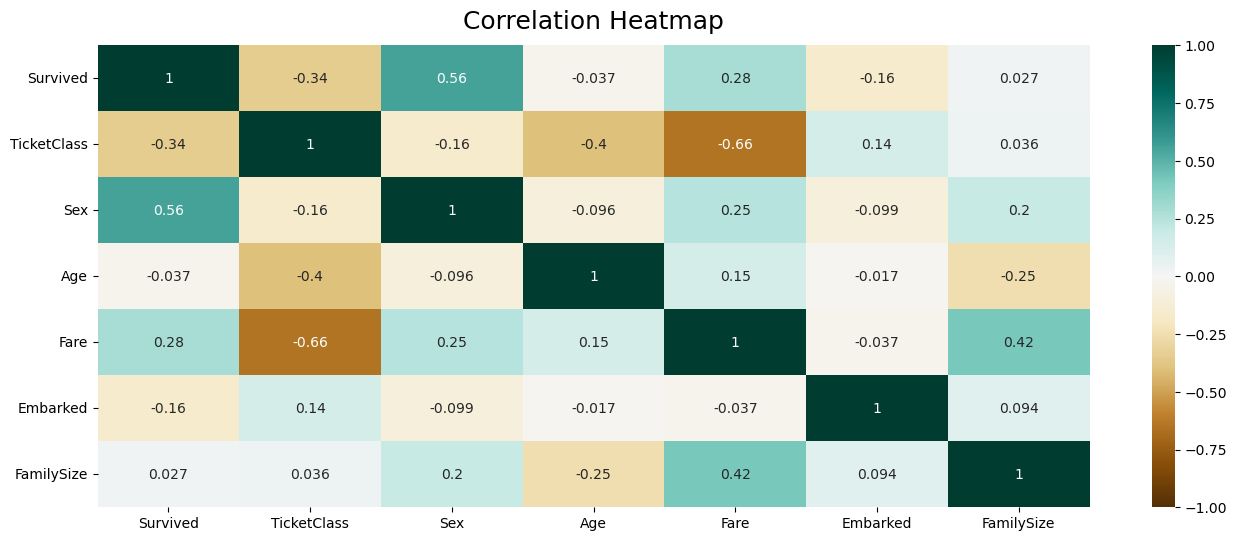

In [20]:
# Creating correlation heatmap on the training dataset
plt.figure(figsize=(16, 6))
correlation_graph = sns.heatmap(train_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
correlation_graph.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

### Feature Corretion

Now that the relationships between variables are generally understood, we can further visualize to get a better understanding of the features and how they interact. This can also explain more when we visualize correlations between features and survival rate.

It can be seen that there is a moderate negative correlation between the "TicketClass" feature and the "Age" as visualized below.

Text(0, 0.5, 'Ticket Class')

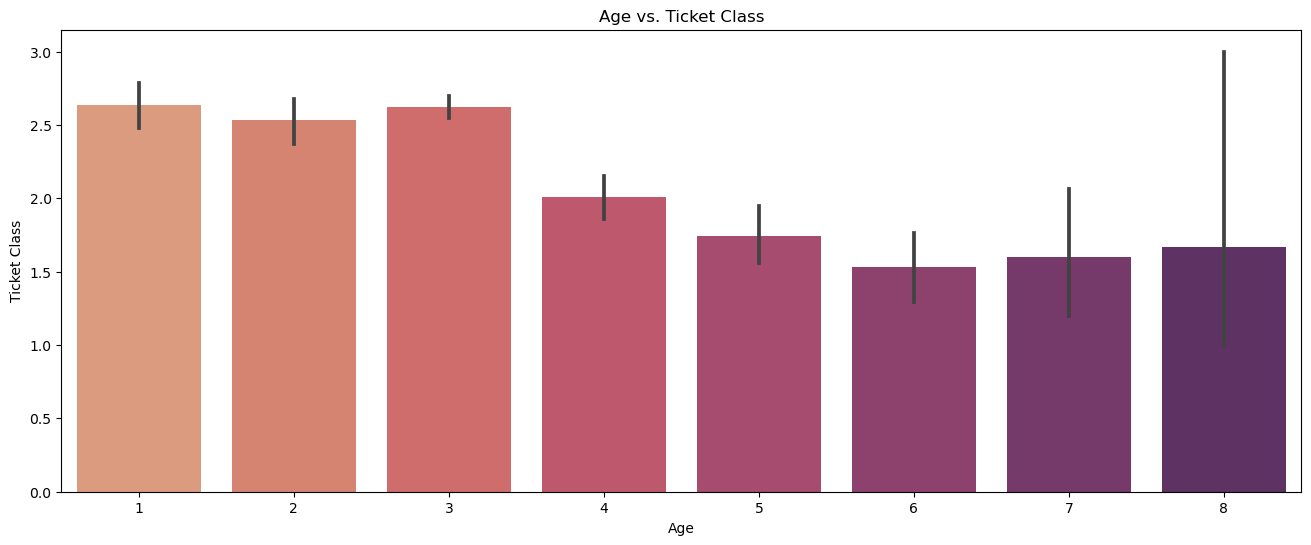

In [21]:
# Create graph showing average ticket class based on age bracket
plt.figure(figsize=(16, 6))
tclass_age_graph = sns.barplot(data=train_df, x="Age", y="TicketClass", palette = "flare")
tclass_age_graph.set_title('Age vs. Ticket Class')
tclass_age_graph.set_xlabel('Age')
tclass_age_graph.set_ylabel('Ticket Class')

This trend can also be explained partially by the weak correlation between age and family size, as larger families are likely to contain children who are of a younger age. However, interestingly enough there is very little correlation between family size and ticket class.

There also exists a weak positive correlation between sex and family size, which means that women tend to embark with more of their family. This makes sense given the gender trends of the time.

Text(0, 0.5, 'Family Size')

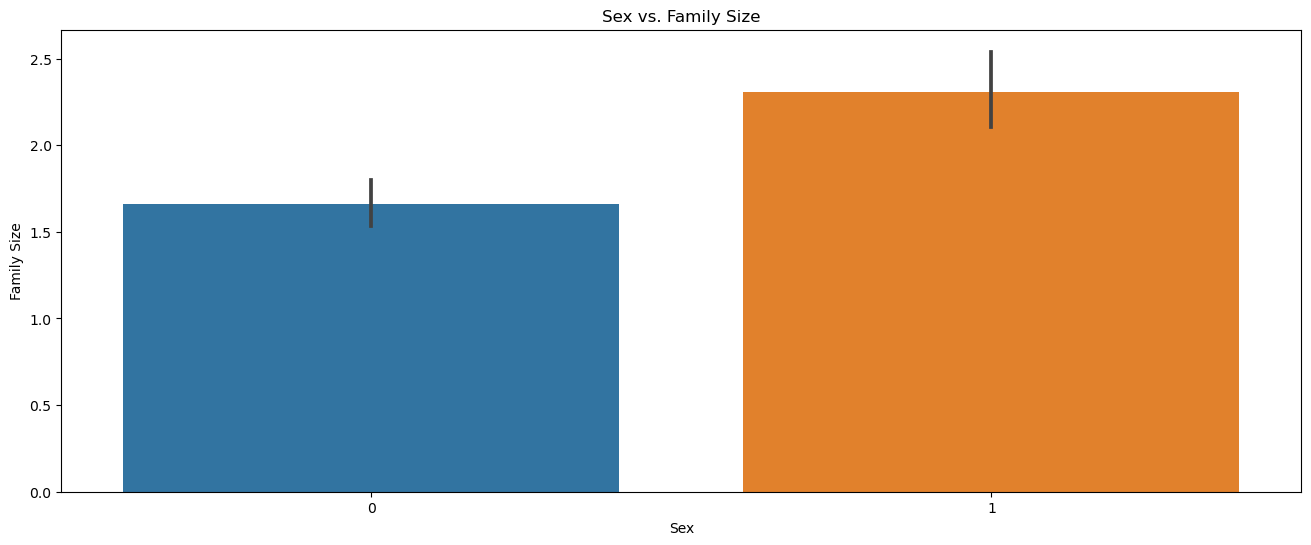

In [22]:
# Create graph showing average family size based on sex
plt.figure(figsize=(16, 6))
family_sex_graph = sns.barplot(data=train_df, x="Sex", y="FamilySize")
family_sex_graph.set_title('Sex vs. Family Size')
family_sex_graph.set_xlabel('Sex')
family_sex_graph.set_ylabel('Family Size')

There are a lot of strong correlations between fare and other features, however due to the existing relationship between family size and sex some of these correlations are redundant. Visualized below is the average fare bracket based on family size.

Text(0, 0.5, 'Fare')

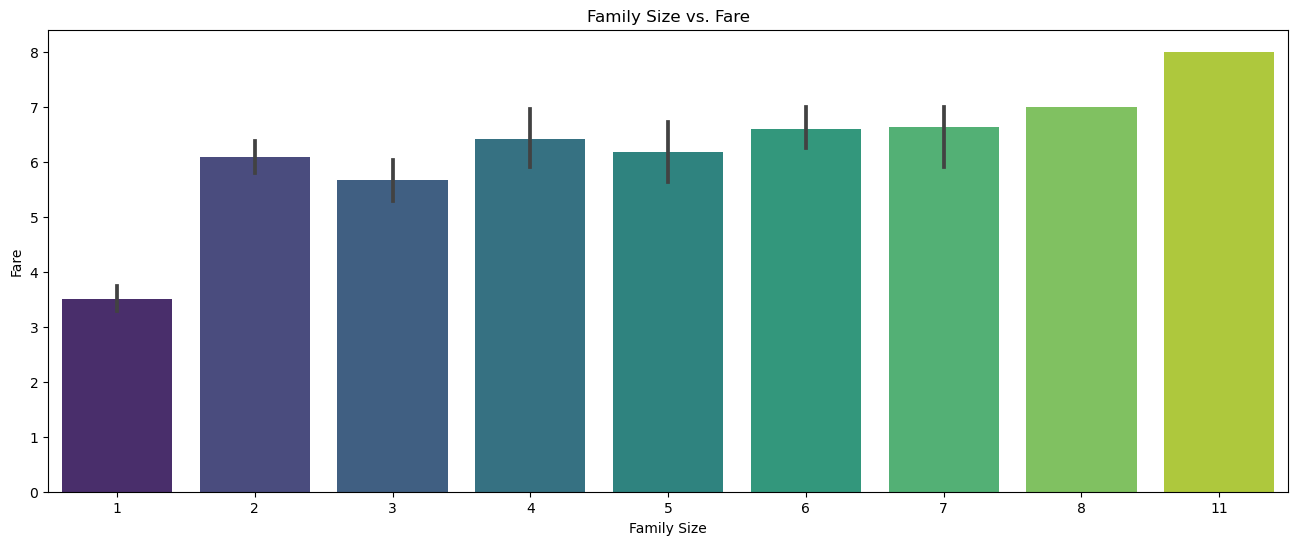

In [23]:
# Create graph showing average fare for each familiy size
plt.figure(figsize=(16, 6))
family_fare_graph = sns.barplot(data=train_df, x="FamilySize", y="Fare", palette = "viridis")
family_fare_graph.set_title('Family Size vs. Fare')
family_fare_graph.set_xlabel('Family Size')
family_fare_graph.set_ylabel('Fare')

There also exists a correlation between fare and ticket class, which is not something that needs to be explored. There also exists a relationship between fare and age which can also be explained by the relationship between age and ticket class.

### Survival Correlation

Now that we understand how other features interact, now we will move on to the correlations between features and survival rate. These are the features that will actually contribute to the model and should definitely be explored. The first correlation is between ticket class and surivival rate which also explains the relationship between fare and survival rate. It would be expected that richer people would be more likely to survive, and it definitely helps that richer passengers tend to be in larger families which have more women and children. Visualized below is the graph showing survival rate based on the ticket class.

Text(0, 0.5, 'Survival Rate')

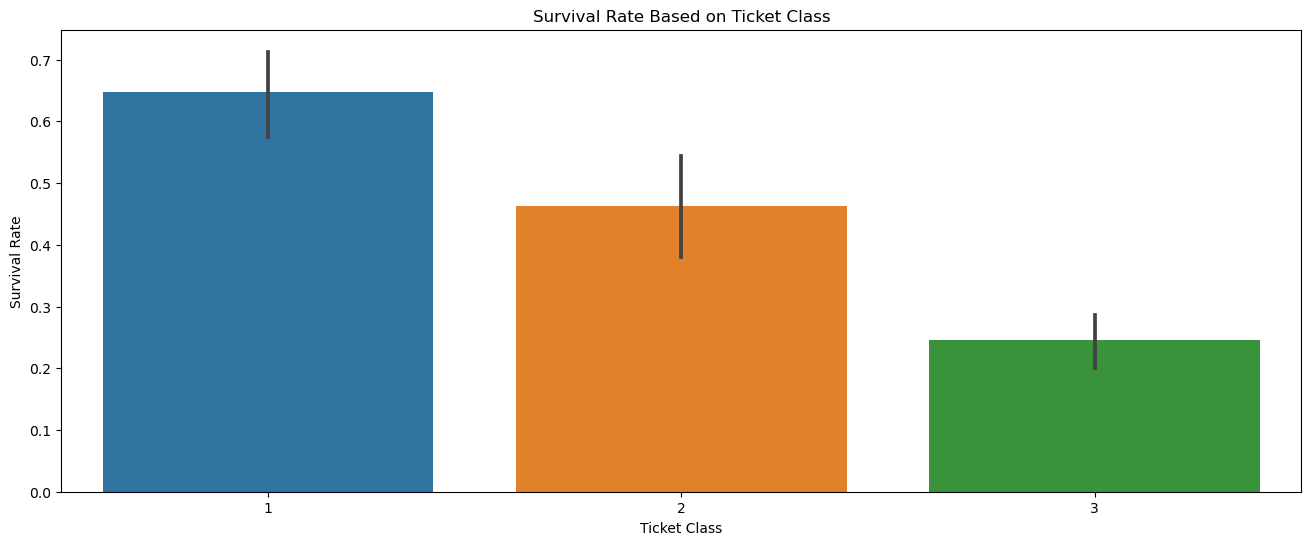

In [24]:
# Create graph showing survival rate based on ticket class
plt.figure(figsize=(16, 6))
tclass_survive_graph = sns.barplot(data=train_df, x="TicketClass", y="Survived")
tclass_survive_graph.set_title('Survival Rate Based on Ticket Class')
tclass_survive_graph.set_xlabel('Ticket Class')
tclass_survive_graph.set_ylabel('Survival Rate')

Another moderate correlation exists between sex and survival rate, which makes sense considering the notion of having the women and children get on the life boats first. This also likely has a relationship with ticket class and should also be taken into account. The survival rates are shown below.

Text(0, 0.5, 'Survival Rate')

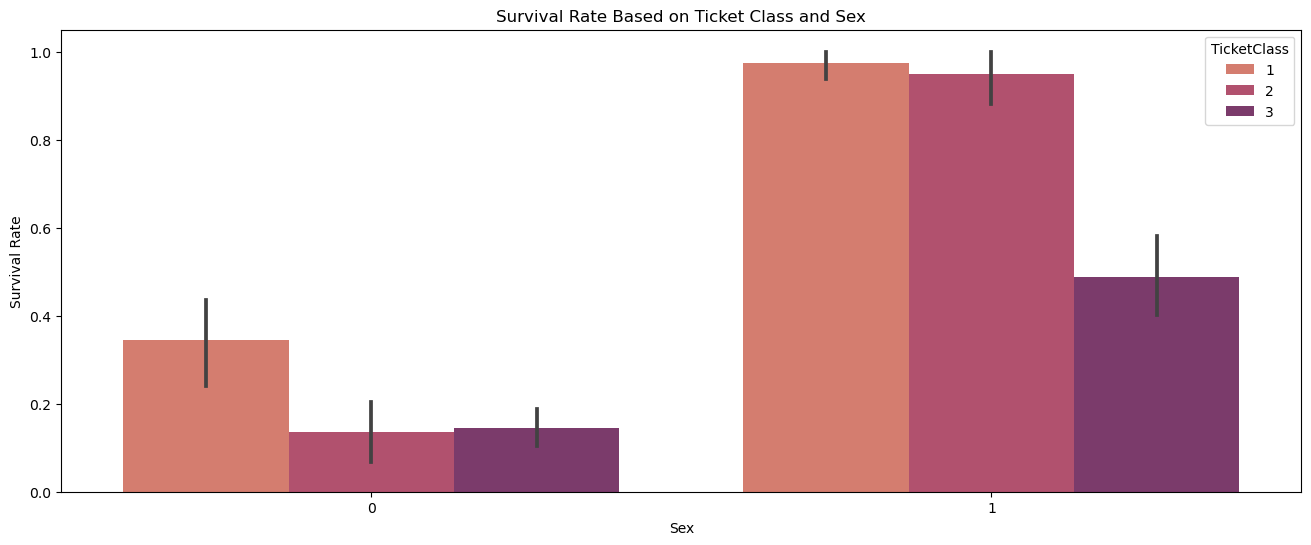

In [25]:
# Create graph showing survival rate based on gender and ticket class
plt.figure(figsize=(16, 6))
tclass_sex_survive_graph = sns.barplot(data=train_df, x="Sex", y="Survived", hue = "TicketClass", palette = "flare")
tclass_sex_survive_graph.set_title('Survival Rate Based on Ticket Class and Sex')
tclass_sex_survive_graph.set_xlabel('Sex')
tclass_sex_survive_graph.set_ylabel('Survival Rate')

The last significant relationship can be seen between survival rate and embarkation, and since the numerical values used to indicate the port the number is not really useful without a visualization, so the survival rates for each port are shown below.

Text(0, 0.5, 'Survival Rate')

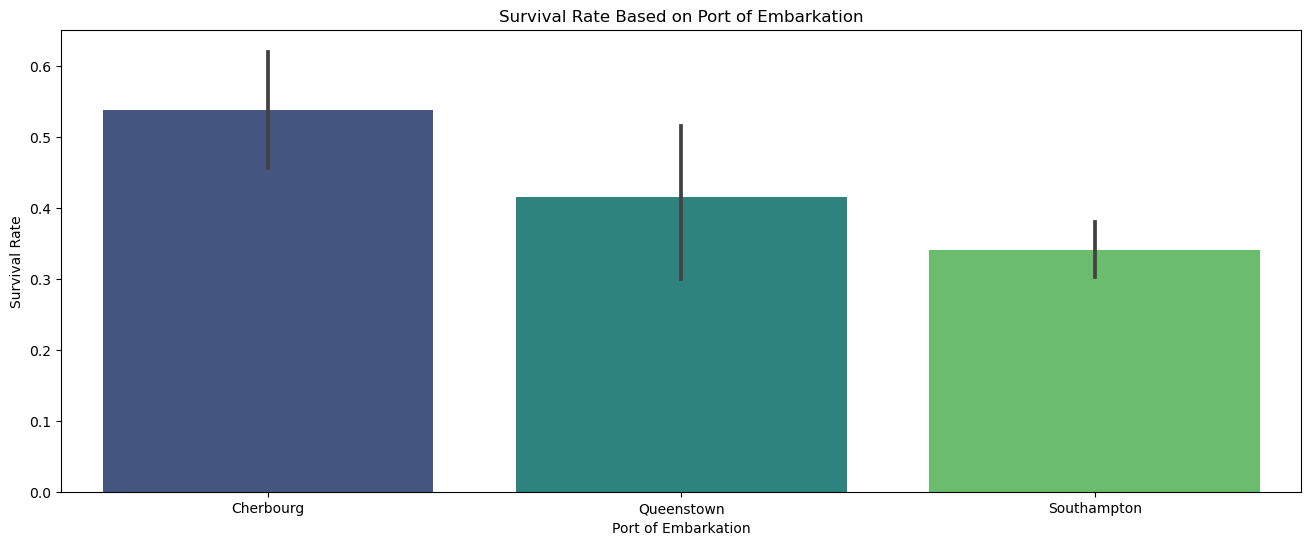

In [26]:
# Create graph showing survival rate based on ticket class
temp = train_df.copy()
temp['Embarked'] = temp['Embarked'].map( {1 : 'Cherbourg', 2 : 'Queenstown', 3 : 'Southampton'} )

plt.figure(figsize=(16, 6))
embark_survive_graph = sns.barplot(data=temp, x="Embarked", y="Survived", palette = "viridis")
embark_survive_graph.set_title('Survival Rate Based on Port of Embarkation')
embark_survive_graph.set_xlabel('Port of Embarkation')
embark_survive_graph.set_ylabel('Survival Rate')

## Modeling

Now that we have analyzed what factors into the chances of a passenger surviving, we can observe how different machine learning algorithms use the given features to predict whether a passenger will survive. For each model three 80/20 and three 60/40 training-testing splits will be used in order to analyze the effect of cross validation on model results. Also, for each model the performance will be test with accuracy, precision, recall, and F-score.

First create the splits for all of the 80/20 and 60/40 models.

In [27]:
# Separate features from target
features = ['TicketClass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize']
target = 'Survived'

# Creating 80/20 training-testing splits
X_train0, X_val0, y_train0, y_val0 = train_test_split(df[features], df[target], test_size=0.2, random_state=26)
X_train1, X_val1, y_train1, y_val1 = train_test_split(df[features], df[target], test_size=0.2, random_state=17)
X_train2, X_val2, y_train2, y_val2 = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

X_train3, X_val3, y_train3, y_val3 = train_test_split(df[features], df[target], test_size=0.4, random_state=87)
X_train4, X_val4, y_train4, y_val4 = train_test_split(df[features], df[target], test_size=0.4, random_state=56)
X_train5, X_val5, y_train5, y_val5 = train_test_split(df[features], df[target], test_size=0.4, random_state=9)

### K-Nearest Neighbors

The K-Nearest Neighbors algorithm is a supervised machine learning algorithm that attempts to predict the correct label, in this case either surviving or not surviving, by calculating the distance between each testing point and all of the training data points. The algorithm then finds the 'K' nearest neighbors to the point in question and calculates the probability that it is a part of one of the labeled classes, with the class with the highest probability being chosen as the correct label.

Now six models will be created and analyed to determine the effiency of this model.

In [28]:
# Initializing lists to store metrics
kn_acc = []
kn_prec = []
kn_rec = []
kn_f = []

# Creating model 0 using k-nearest neighbors
kn0 = KNeighborsClassifier()
kn0.fit(X_train0, y_train0)
y_pred0 = kn0.predict(X_val0)
kn_acc.append(metric.accuracy_score(y_val0, y_pred0))
kn_prec.append(metric.precision_score(y_val0, y_pred0))
kn_rec.append(metric.recall_score(y_val0, y_pred0))
kn_f.append(metric.f1_score(y_val0, y_pred0))

In [29]:
# Creating model 1 using k-nearest neighbors
kn1 = KNeighborsClassifier()
kn1.fit(X_train1, y_train1)
y_pred1 = kn1.predict(X_val1)
kn_acc.append(metric.accuracy_score(y_val1, y_pred1))
kn_prec.append(metric.precision_score(y_val1, y_pred1))
kn_rec.append(metric.recall_score(y_val1, y_pred1))
kn_f.append(metric.f1_score(y_val1, y_pred1))

In [30]:
# Creating model 2 using k-nearest neighbors
kn2 = KNeighborsClassifier()
kn2.fit(X_train2, y_train2)
y_pred2 = kn2.predict(X_val2)
kn_acc.append(metric.accuracy_score(y_val2, y_pred2))
kn_prec.append(metric.precision_score(y_val2, y_pred2))
kn_rec.append(metric.recall_score(y_val2, y_pred2))
kn_f.append(metric.f1_score(y_val2, y_pred2))

In [31]:
# Creating model 3 using k-nearest neighbors
kn3 = KNeighborsClassifier()
kn3.fit(X_train3, y_train3)
y_pred3 = kn3.predict(X_val3)
kn_acc.append(metric.accuracy_score(y_val3, y_pred3))
kn_prec.append(metric.precision_score(y_val3, y_pred3))
kn_rec.append(metric.recall_score(y_val3, y_pred3))
kn_f.append(metric.f1_score(y_val3, y_pred3))

In [32]:
# Creating model 4 using k-nearest neighbors
kn4 = KNeighborsClassifier()
kn4.fit(X_train4, y_train4)
y_pred4 = kn4.predict(X_val4)
kn_acc.append(metric.accuracy_score(y_val4, y_pred4))
kn_prec.append(metric.precision_score(y_val4, y_pred4))
kn_rec.append(metric.recall_score(y_val4, y_pred4))
kn_f.append(metric.f1_score(y_val4, y_pred4))

In [33]:
# Creating model 5 using k-nearest neighbors
kn5 = KNeighborsClassifier()
kn5.fit(X_train5, y_train5)
y_pred5 = kn5.predict(X_val5)
kn_acc.append(metric.accuracy_score(y_val5, y_pred5))
kn_prec.append(metric.precision_score(y_val5, y_pred5))
kn_rec.append(metric.recall_score(y_val5, y_pred5))
kn_f.append(metric.f1_score(y_val5, y_pred5))

Now that the models have been created and the performance metrics have been recorded, lets see how the models performed.

In [34]:
# Creating dataframes to store performance metrics
kn_df = pd.DataFrame({'Split': ['80/20', '80/20', '80/20', '60/40', '60/40', '60/40']})
kn_df['Accuracy'] = kn_acc
kn_df['Precision'] = kn_prec
kn_df['Recall'] = kn_rec
kn_df['F-score'] = kn_f

print("All K-Nearest Neighbors Model Performances")
print(kn_df)
print("_"*50)

print("Model Performance by Split")
kn_df_split_mean = kn_df.groupby('Split').mean()
print(kn_df_split_mean)
print("_"*50)

print("Average Performance")
kn_df_mean = kn_df.mean(numeric_only = True)
print(kn_df_mean)

All K-Nearest Neighbors Model Performances
   Split  Accuracy  Precision    Recall   F-score
0  80/20  0.793296   0.685714  0.761905  0.721805
1  80/20  0.759777   0.708333  0.698630  0.703448
2  80/20  0.821229   0.808824  0.743243  0.774648
3  60/40  0.801120   0.780303  0.710345  0.743682
4  60/40  0.803922   0.725191  0.736434  0.730769
5  60/40  0.764706   0.763158  0.604167  0.674419
__________________________________________________
Model Performance by Split
       Accuracy  Precision    Recall  F-score
Split                                        
60/40  0.789916   0.756217  0.683649  0.71629
80/20  0.791434   0.734290  0.734593  0.73330
__________________________________________________
Average Performance
Accuracy     0.790675
Precision    0.745254
Recall       0.709121
F-score      0.724795
dtype: float64


As seen above it seems like the 80/20 split performed better overall only being beat out in the precision metric, but we can see a decent amount of variation in the metrics for each model in the cross validation revealing some training sets are better than others. Overall, the performance was pretty strong with accuracy having an impressive score with precision not far behind. The recall and F-score performance methods did not perform as well but both remain above 0.70.

### Stochastic Gradient Descent

This is a linear regression algorithm which has the goal of minimizing the sum of squared residuals by finding the gradient of the function. The stochastic part of this algorithm is in determining the initial value of parameters, updating the gradient function using these random parameters. Then the step sizes are calculated based on the gradient and learning rate in order to determine a new set of parameters for the next step. This keeps repeating until a sufficient gradient is found, or optimally where the global minimum is at a gradient of zero. This is essentially what creates the decision boundary and allows us to classify the passenger as a survivor or not.

Now six models will be created and analyed to determine the effiency of this model.

In [35]:
# Initializing lists to store metrics
sgd_acc = []
sgd_prec = []
sgd_rec = []
sgd_f = []

# Creating model 0 using stochastic gradient descent
sgd0 = SGDClassifier()
sgd0.fit(X_train0, y_train0)
y_pred0 = sgd0.predict(X_val0)
sgd_acc.append(metric.accuracy_score(y_val0, y_pred0))
sgd_prec.append(metric.precision_score(y_val0, y_pred0))
sgd_rec.append(metric.recall_score(y_val0, y_pred0))
sgd_f.append(metric.f1_score(y_val0, y_pred0))

In [36]:
# Creating model 1 using stochastic gradient descent
sgd1 = SGDClassifier()
sgd1.fit(X_train1, y_train1)
y_pred1 = sgd1.predict(X_val1)
sgd_acc.append(metric.accuracy_score(y_val1, y_pred1))
sgd_prec.append(metric.precision_score(y_val1, y_pred1))
sgd_rec.append(metric.recall_score(y_val1, y_pred1))
sgd_f.append(metric.f1_score(y_val1, y_pred1))

In [37]:
# Creating model 2 using stochastic gradient descent
sgd2 = SGDClassifier()
sgd2.fit(X_train2, y_train2)
y_pred2 = sgd2.predict(X_val2)
sgd_acc.append(metric.accuracy_score(y_val2, y_pred2))
sgd_prec.append(metric.precision_score(y_val2, y_pred2))
sgd_rec.append(metric.recall_score(y_val2, y_pred2))
sgd_f.append(metric.f1_score(y_val2, y_pred2))

In [38]:
# Creating model 3 using stochastic gradient descent
sgd3 = SGDClassifier()
sgd3.fit(X_train3, y_train3)
y_pred3 = sgd3.predict(X_val3)
sgd_acc.append(metric.accuracy_score(y_val3, y_pred3))
sgd_prec.append(metric.precision_score(y_val3, y_pred3))
sgd_rec.append(metric.recall_score(y_val3, y_pred3))
sgd_f.append(metric.f1_score(y_val3, y_pred3))

In [39]:
# Creating model 4 using stochastic gradient descent
sgd4 = SGDClassifier()
sgd4.fit(X_train4, y_train4)
y_pred4 = sgd4.predict(X_val4)
sgd_acc.append(metric.accuracy_score(y_val4, y_pred4))
sgd_prec.append(metric.precision_score(y_val4, y_pred4))
sgd_rec.append(metric.recall_score(y_val4, y_pred4))
sgd_f.append(metric.f1_score(y_val4, y_pred4))

In [40]:
# Creating model 5 using stochastic gradient descent
sgd5 = SGDClassifier()
sgd5.fit(X_train5, y_train5)
y_pred5 = sgd5.predict(X_val5)
sgd_acc.append(metric.accuracy_score(y_val5, y_pred5))
sgd_prec.append(metric.precision_score(y_val5, y_pred5))
sgd_rec.append(metric.recall_score(y_val5, y_pred5))
sgd_f.append(metric.f1_score(y_val5, y_pred5))

Now that the models have been created and the performance metrics have been recorded, lets see how the models performed.

In [41]:
# Creating dataframes to store performance metrics
sgd_df = pd.DataFrame({'Split': ['80/20', '80/20', '80/20', '60/40', '60/40', '60/40']})
sgd_df['Accuracy'] = sgd_acc
sgd_df['Precision'] = sgd_prec
sgd_df['Recall'] = sgd_rec
sgd_df['F-score'] = sgd_f

print("All K-Nearest Neighbors Model Performances")
print(sgd_df)
print("_"*50)

print("Model Performance by Split")
sgd_df_split_mean = sgd_df.groupby('Split').mean()
print(sgd_df_split_mean)
print("_"*50)

print("Average Performance")
sgd_df_mean = sgd_df.mean(numeric_only = True)
print(sgd_df_mean)

All K-Nearest Neighbors Model Performances
   Split  Accuracy  Precision    Recall   F-score
0  80/20  0.793296   0.709677  0.698413  0.704000
1  80/20  0.754190   0.723077  0.643836  0.681159
2  80/20  0.782123   0.818182  0.608108  0.697674
3  60/40  0.694678   0.577586  0.924138  0.710875
4  60/40  0.795518   0.764151  0.627907  0.689362
5  60/40  0.775910   0.833333  0.555556  0.666667
__________________________________________________
Model Performance by Split
       Accuracy  Precision    Recall   F-score
Split                                         
60/40  0.755369   0.725023  0.702533  0.688968
80/20  0.776536   0.750312  0.650119  0.694278
__________________________________________________
Average Performance
Accuracy     0.765953
Precision    0.737668
Recall       0.676326
F-score      0.691623
dtype: float64


Overall compared to the K-Nearest Neighbors algorithm this model did not perform as well, failing to get above 0.70 in the overall precision metric and barely squeaking by for F-score. It is also clear that the 80/20 split is much more favorable for this model as the differences in performance metrics are significant. Once again cross validation proved to show that certain sets of the training data are definitely more suitable than others, with precision metrics ranging from around 0.57 to 0.84.

### Random Forest

The random forest algorithm makes use of decision trees in order to classify a point. The algorithm randomly takes a subsets of data points and features to create a "forest" of decision trees. Each decision tree will generate a classifying output based on what data is put into it and therefore this creates a large amount of different classifications from the many random decision trees. The final classification is determined by majority voting of the random decision trees in the "forest".

Now six models will be created and analyed to determine the effiency of this model.

In [42]:
# Initializing lists to store metrics
forest_acc = []
forest_prec = []
forest_rec = []
forest_f = []

# Creating model 0 using random forest
forest0 = RandomForestClassifier(random_state=26)
forest0.fit(X_train0, y_train0)
y_pred0 = forest0.predict(X_val0)
forest_acc.append(metric.accuracy_score(y_val0, y_pred0))
forest_prec.append(metric.precision_score(y_val0, y_pred0))
forest_rec.append(metric.recall_score(y_val0, y_pred0))
forest_f.append(metric.f1_score(y_val0, y_pred0))

In [43]:
# Creating model 1 using random forest
forest1 = RandomForestClassifier(random_state=17)
forest1.fit(X_train1, y_train1)
y_pred1 = forest1.predict(X_val1)
forest_acc.append(metric.accuracy_score(y_val1, y_pred1))
forest_prec.append(metric.precision_score(y_val1, y_pred1))
forest_rec.append(metric.recall_score(y_val1, y_pred1))
forest_f.append(metric.f1_score(y_val1, y_pred1))

In [44]:
# Creating model 2 using random forest
forest2 = RandomForestClassifier(random_state=42)
forest2.fit(X_train2, y_train2)
y_pred2 = forest2.predict(X_val2)
forest_acc.append(metric.accuracy_score(y_val2, y_pred2))
forest_prec.append(metric.precision_score(y_val2, y_pred2))
forest_rec.append(metric.recall_score(y_val2, y_pred2))
forest_f.append(metric.f1_score(y_val2, y_pred2))

In [45]:
# Creating model 3 using random forest
forest3 = RandomForestClassifier(random_state=87)
forest3.fit(X_train3, y_train3)
y_pred3 = forest3.predict(X_val3)
forest_acc.append(metric.accuracy_score(y_val3, y_pred3))
forest_prec.append(metric.precision_score(y_val3, y_pred3))
forest_rec.append(metric.recall_score(y_val3, y_pred3))
forest_f.append(metric.f1_score(y_val3, y_pred3))

In [46]:
# Creating model 4 using random forest
forest4 = RandomForestClassifier(random_state=56)
forest4.fit(X_train4, y_train4)
y_pred4 = forest4.predict(X_val4)
forest_acc.append(metric.accuracy_score(y_val4, y_pred4))
forest_prec.append(metric.precision_score(y_val4, y_pred4))
forest_rec.append(metric.recall_score(y_val4, y_pred4))
forest_f.append(metric.f1_score(y_val4, y_pred4))

In [47]:
# Creating model 5 using random forest
forest5 = RandomForestClassifier(random_state=26)
forest5.fit(X_train5, y_train5)
y_pred5 = forest5.predict(X_val5)
forest_acc.append(metric.accuracy_score(y_val5, y_pred5))
forest_prec.append(metric.precision_score(y_val5, y_pred5))
forest_rec.append(metric.recall_score(y_val5, y_pred5))
forest_f.append(metric.f1_score(y_val5, y_pred5))

Now that the models have been created and the performance metrics have been recorded, lets see how the models performed.

In [48]:
# Creating dataframes to store performance metrics
forest_df = pd.DataFrame({'Split': ['80/20', '80/20', '80/20', '60/40', '60/40', '60/40']})
forest_df['Accuracy'] = forest_acc
forest_df['Precision'] = forest_prec
forest_df['Recall'] = forest_rec
forest_df['F-score'] = forest_f

print("All Forest Model Performances")
print(forest_df)
print("_"*50)

print("Model Performance by Split")
forest_df_split_mean = forest_df.groupby('Split').mean()
print(forest_df_split_mean)
print("_"*50)

print("Average Performance")
forest_df_mean = forest_df.mean(numeric_only = True)
print(forest_df_mean)

All Forest Model Performances
   Split  Accuracy  Precision    Recall   F-score
0  80/20  0.821229   0.746032  0.746032  0.746032
1  80/20  0.765363   0.724638  0.684932  0.704225
2  80/20  0.821229   0.791667  0.770270  0.780822
3  60/40  0.801120   0.784615  0.703448  0.741818
4  60/40  0.806723   0.730769  0.736434  0.733591
5  60/40  0.806723   0.837838  0.645833  0.729412
__________________________________________________
Model Performance by Split
       Accuracy  Precision    Recall   F-score
Split                                         
60/40  0.804855   0.784407  0.695239  0.734940
80/20  0.802607   0.754112  0.733745  0.743693
__________________________________________________
Average Performance
Accuracy     0.803731
Precision    0.769260
Recall       0.714492
F-score      0.739317
dtype: float64


The random forest method seems to have better metrics overall than the previous two models, showing better accuracy, precision, and F-score than them on average. Interestingly the splits of training and testing data did not have too significant of an effect on performance, with only precision and recall varying significantly. It also seems like the metrics for each individual model did not vary as much as it did for the other algorithms.

### Overall Performance Metrics

Now that we have data for all three different algorithms, we can tabulate and graph the overall statistics to get a better visualization on their performance.

In [49]:
# Print all metrics in table form
metrics = {'Test': ['K-N Neighbors', 'SGD', 'Random Forest'], 
     'Accuracy': [kn_df_mean[0], sgd_df_mean[0], forest_df_mean[0]],
     'Precision': [kn_df_mean[1], sgd_df_mean[1], forest_df_mean[1]],
     'Recall': [kn_df_mean[2], sgd_df_mean[2], forest_df_mean[2]],
     'F-score': [kn_df_mean[3], sgd_df_mean[3], forest_df_mean[3]]}
df_metrics = pd.DataFrame(data=metrics)
print(df_metrics.to_string(index = False))

         Test  Accuracy  Precision   Recall  F-score
K-N Neighbors  0.790675   0.745254 0.709121 0.724795
          SGD  0.765953   0.737668 0.676326 0.691623
Random Forest  0.803731   0.769260 0.714492 0.739317


<Figure size 1600x600 with 0 Axes>

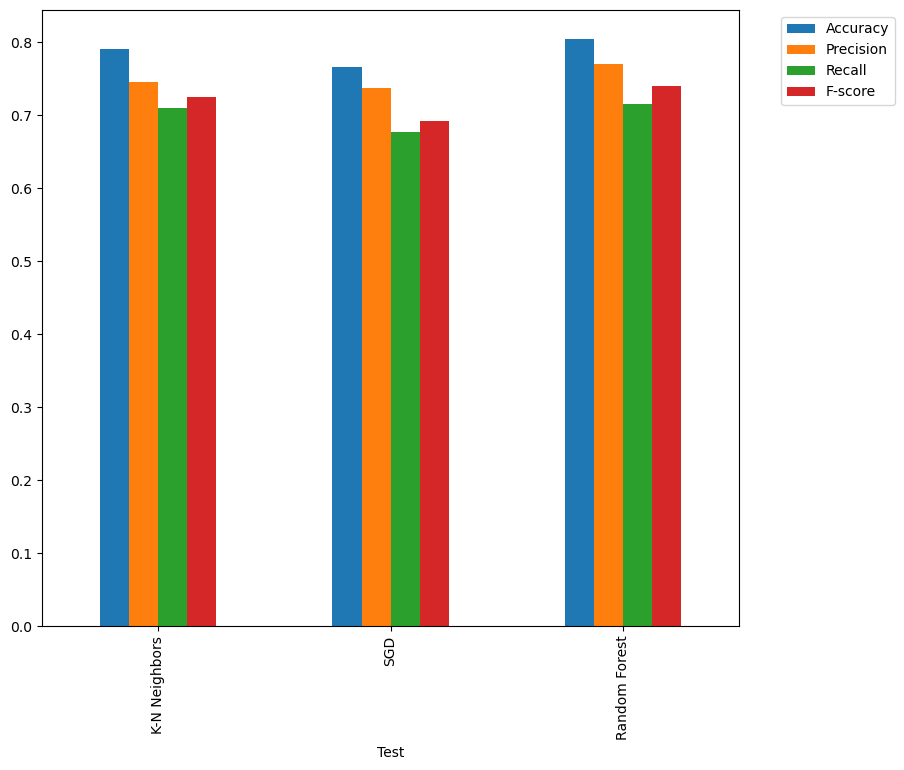

In [50]:
plt.figure(figsize=(16, 6))
df_metrics.plot(x="Test", y=["Accuracy", "Precision", "Recall", "F-score"], kind="bar", figsize=(9, 8))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Overall we can see that certain models favor certain performance metrics, but it seems like the the sake of predicting the survival of Titanic passengers Random Forest is probably your best bet. However, each model did perform very well scoring above 0.70 on most metrics and even hitting 0.80 on occasion. This shows that the data wrangling that was done leads to pretty effective results and that the exploratory data analysis was a success.